# Ungraded Lab Part 1 - Deploying a Machine Learning Model

Welcome to this ungraded lab!

This lab is all about seeing how it feels to deploy a real machine learning model. You will deploy a computer vision model trained to detect common objects in images. Typically, deploying the model is one of the last steps in a machine learning lifecycle. However, we thought it would be exciting to get you to deploy a model right away. This lab employs a pretrained object detection model called `YOLOV3`. This model is very convenient for two reasons: it runs really fast, and it yields accurate results.

In this lab, you will:
1. Inspect the image data set used for object detection
2. Take a look at the model itself
3. Deploy the model using FastAPI

## Why deployment?

It's great to have a model working in a notebook. In practice, though, you will get much more use out of your model when its predictions can be accessed quickly and easily by others who may not have the technical know-how to interact with a notebook. Deploying your object detection model transforms it from a prototype into a practical tool that can be integrated into applications, websites, and other systems. This means your hard work can actually be put to use in real-world scenarios.

For instance, deploying the YOLOV3 model would allow developers on your team to incorporate its functionality into a mobile app or surveillance system. Users could then benefit from real-time object detection, whether it's for identifying products in a shopping app or enhancing their security.

## Why FastAPI?

With FastAPI you can create web servers to host your models very easily, without having to build a complete web application or write any boilerplate. FastAPI handles the complex work behind the scenes, allowing you to write robust apps with straightforward code. Additionally, FastAPI is, well, very fast and it **has a built-in client that can be used to interact with the server**.

## Object Detection with YOLOV3

### Inspecting the images

In this section, you'll use 🔗[`YOLOV3`](https://pjreddie.com/darknet/yolo/) for an object detection task.

Let's take a look at the images that will be passed to the YOLOV3 model. Scanning the images will help you form an intuition about what types of objects will be detected. These images are part of the 🔗[`ImageNet`](http://www.image-net.org/index) dataset.

In [1]:
from IPython.display import Image, display


Displaying image: apple.jpg


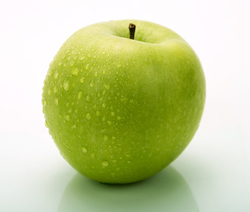


Displaying image: clock.jpg


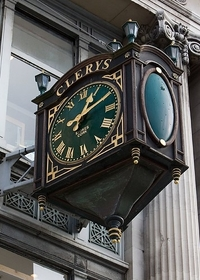


Displaying image: oranges.jpg


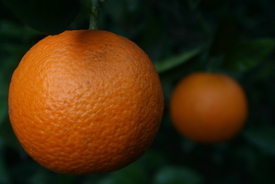


Displaying image: car.jpg


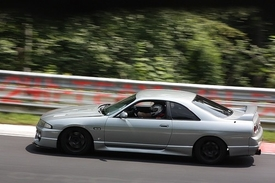

In [2]:
# Some example images
image_files = [
    'apple.jpg',
    'clock.jpg',
    'oranges.jpg',
    'car.jpg'
]

for image_file in image_files:
    print(f"\nDisplaying image: {image_file}")
    display(Image(filename=f"images/{image_file}"))

### Overview of the model


Now that you have a sense of the image data you're working with, you will check how accurately the model can detect and classify them.

For this task, you will use 🔗[`cvlib`](https://github.com/arunponnusamy/cvlib), which is a very simple but powerful library for object detection that is fueled by 🔗[`OpenCV`](https://docs.opencv.org/4.5.1/) and 🔗[`Tensorflow`](https://www.tensorflow.org/).

You will use the 🔗[`detect_common_objects`](https://github.com/arunponnusamy/cvlib/tree/master/docs#object-detection) function from `cvlib`, which takes an image formatted as a 🔗[`numpy array`](https://numpy.org/doc/stable/reference/generated/numpy.array.html) and returns the code below.

- `bbox`: list of lists containing bounding box coordinates for detected objects. 

        Example:
    
    ```python
        [[32, 76, 128, 192], [130, 83, 220, 185]]
    ```
    

- `label`: list of labels for detected objects.
    
        Example:
    ```python
        ['orange', 'orange']
    ```


- `conf`: list of confidence scores for detected objects. A confidence score reflects the model's certainty that the object is really in the image.
        Example:
        
    ```python
        [0.6187325716018677, 0.42835739254951477]
    ```
    

Here's what a saved image with bounding boxes and labels might look like. It's important to understand the expected output from your model when deploying, so you can better communicate with your users.

![two oranges detected by YOLOV3](images/oranges_with_bbox.jpeg)

### Creating the detect_and_draw_box function

Next, you'll create a function that will allow users to interact with your model when it is deployed, called `detect_and_draw_box`. When a user needs to have the model detect objects in an image, FastAPI will use this function. 

First, create a directory where you can store the resulting images:


In [3]:
import os

dir_name = "images_with_boxes"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

Let's define the `detect_and_draw_box` function which takes as input arguments: the **filename** of a file on your system, a **model**, and a **confidence level**. With these inputs, it detects common objects in the image and saves a new image displaying the bounding boxes alongside the detected object.

This function receives the model as an input argument because you have options for which model to use. Going forward, you should use `yolov3-tiny`, a model designed for constrained environments. This model is less accurate than the full model, but still works pretty well. Downloading its pretrained weights takes less time.

Recall that the model's output is a vector of probabilities representing the model's confidence that a particular object is in the image at a particular location. The function will use its last input argument, confidence level, to determine the threshold that the probability needs to surpass to report that a given object is detected in the supplied image. By default, `detect_common_objects` uses a value of 0.5. That is, if the model is more than 50% confident in the location of an object in the image, it will draw the bounding box in the newly saved image.

In [4]:
import cv2

# suppress Tensorflow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import cvlib as cv
from cvlib.object_detection import draw_bbox


def detect_and_draw_box(filename, model="yolov3-tiny", confidence=0.5):
    """Detects common objects on an image and creates a new image with bounding boxes.

    Args:
        filename (str): Filename of the image.
        model (str): Either "yolov3" or "yolov3-tiny". Defaults to "yolov3-tiny".
        confidence (float, optional): Desired confidence level. Defaults to 0.5.
    """
    
    # Images are stored under the images/ directory
    img_filepath = f'images/{filename}'
    
    # Read the image into a numpy array
    img = cv2.imread(img_filepath)
    
    # Perform the object detection
    bbox, label, conf = cv.detect_common_objects(img, confidence=confidence, model=model)
    
    # Print current image's filename
    print(f"========================\nImage processed: {filename}\n")
    
    # Print detected objects with confidence level
    for l, c in zip(label, conf):
        print(f"Detected object: {l} with confidence level of {c}\n")
    
    # Create a new image that includes the bounding boxes
    output_image = draw_bbox(img, bbox, label, conf)
    
    # Save the image in the directory images_with_boxes
    cv2.imwrite(f'images_with_boxes/{filename}', output_image)
    
    # Display the image with bounding boxes
    display(Image(f'images_with_boxes/{filename}'))

Let's try it out for the example images.

Image processed: apple.jpg

Detected object: apple with confidence level of 0.5717183351516724



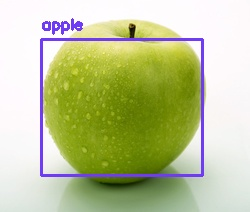

Image processed: clock.jpg

Detected object: clock with confidence level of 0.968317985534668



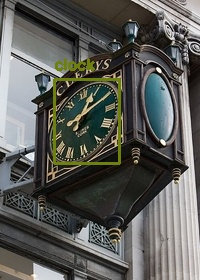

Image processed: oranges.jpg

Detected object: orange with confidence level of 0.6185599565505981

Detected object: orange with confidence level of 0.5561732053756714



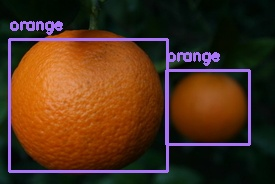

Image processed: car.jpg

Detected object: car with confidence level of 0.6325422525405884



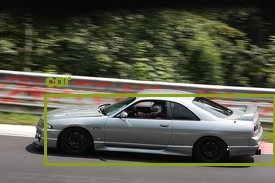

In [5]:
for image_file in image_files:
    detect_and_draw_box(image_file)

## Changing the confidence level

Looks like the object detection went fairly well. Let's try it out on a more difficult image containing several objects:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818485617637634

Detected object: orange with confidence level of 0.5346476435661316

Detected object: orange with confidence level of 0.5150948166847229



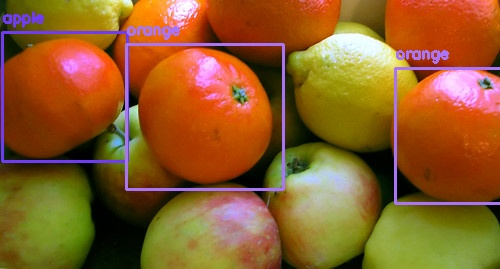

In [6]:
detect_and_draw_box("fruits.jpg")

The **model failed to detect** several fruits and **misclassified** an orange as an apple. This might seem strange since it was able to detect one apple before, so one might think the model has a fair representation on how an apple looks like.

One possibility is that the model **did** detect the other fruits but with a confidence level lower than 0.5. Let's test if  this is a valid hypothesis:

Image processed: fruits.jpg

Detected object: apple with confidence level of 0.5818485617637634

Detected object: orange with confidence level of 0.5346476435661316

Detected object: orange with confidence level of 0.5150948166847229

Detected object: apple with confidence level of 0.3476020395755768

Detected object: orange with confidence level of 0.32876279950141907

Detected object: apple with confidence level of 0.3124457597732544

Detected object: orange with confidence level of 0.27985894680023193

Detected object: orange with confidence level of 0.27499887347221375

Detected object: apple with confidence level of 0.2744504511356354

Detected object: orange with confidence level of 0.21419422328472137



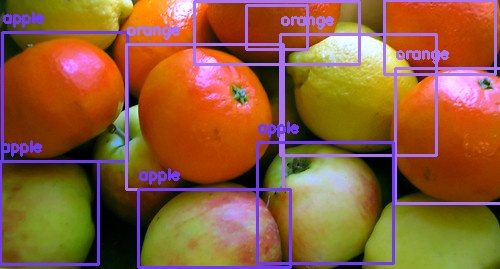

In [7]:
detect_and_draw_box("fruits.jpg", confidence=0.2)

By lowering the confidence level, the model successfully detected most of the fruits. However, you can see that some of them are misclassified (e.g. the label says "orange" but it's actually an apple or lemon). This is usually the case when the confidence level is really low. In general, you should be careful when altering parameters like this one, as changing them might yield undesired results. Be mindful of the type of environment where you will be deploying your model: is a quick but inaccurate predication more desirable, or is accuracy more important?

As for this concrete example when an orange was misclassified as an apple, it serves as a reminder that these models are not perfect and this should be considered when using them for tasks in production.

## Deploying the model using FastAPI

### Placing your object detection model in a server

Now that you know how the model works it is time for you to deploy it! Aren't you excited? :)

Before diving into deployment, let's quickly recap some important concepts and how they translate to `FastAPI`. 🔗[You can access the FastAPI docs here.](https://fastapi.tiangolo.com/) Let's also create a directory to store the images that are uploaded to the server.


In [8]:
dir_name = "images_uploaded"
if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### Review: client-server model, HTTP requests, endpoints

Below, you'll find review sections for the client-server model, HTTP requests, and endpoints. Please review these as necessary skipping any sections you feel comfortable with.

#### Client-Server model

**Deployment** typically means putting all of the software required for predicting in a `server`. By doing so, a `client` can interact with the model by sending `requests` to the server. The `server` is similar to a waiter at a restaurant who brings the `client` what they order. The `client` will make `requests` to the `server`, who can respond to those requests with a defined set of options, like bringing food, explaining the menu, or even denying the request if s/he can't complete it.

This full client-server interaction is out of the scope of this notebook but, there are a few key concepts you should know.

Specifically, the Machine Learning model lives in a server waiting for clients to submit prediction requests. The client should provide the required information that the model needs in order to make a prediction. It's common to batch many predictions in a single request. The server will use the information provided to return predictions to the client, who can then use them at their leisure. The client communicates with the server using its `API`, a defined way of interacting with its code.

Here's an example. In the next section, you'll get started by creating an instance of the `FastAPI` class:

```python
app = FastAPI()
```

Then, you'll use this instance to create endpoints that handle the prediction logic (see more info about endpoints below). Once all the code is in place to run the server, you only need to use the command:

```python
uvicorn.run(app)
```

Your API is coded using FastAPI, but the serving is done using 🔗[`uvicorn`](https://www.uvicorn.org/), which is a really fast Asynchronous Server Gateway Interface (ASGI) implementation. Both technologies are closely interconnected and you don't need to understand the implementation details. Knowing that uvicorn handles the serving is sufficient for the purpose of this lab.

#### HTTP Requests

The client and the server communicate with each other through a protocol called `HTTP` (hypertext transfer protocol). This communication between client and server defines common actions called **requests** using verbs. Two very common requests are:

- `GET` -> Retrieves information from the server.
- `POST` -> Provides information to the server, which it uses to respond.

If your client does a `GET request`, you will get some information from the server without the need to provide additional information. In the case of a `POST request`, you are explicitly telling the server that you will provide some information for it that must be processed in some way. It's similar to social media: if you're just viewing a page (`GET`), the server doesn't need any extra information; if you're making a post or comment (`POST`), you'll need to tell the server what it is you want to say.

Interactions with Machine Learning models living in a server are usually done via a `POST request`, since you need to provide the information that is required to compute a prediction.

#### Endpoints

You can host multiple Machine Learning models on the same server. For this to work, you can assign a different `endpoint` to each model so you always know what model is being used. An endpoint is represented by a pattern in the `URL`, and you can think of it as a place your client can send requests to. For example, if you have a website called `myawesomemodel.com` you could have three different models in the following endpoints:

- `myawesomemodel.com/count-cars/`
- `myawesomemodel.com/count-apples/`
- `myawesomemodel.com/count-plants/`

Each model would do what the name pattern suggests.

With FastAPI, you define an endpoint by first creating a function that will handle all of the logic for that endpoint. Then, you will 🔗[decorate it](https://www.geeksforgeeks.org/decorators-in-python/) with a function that contains information about the HTTP method and URL pattern that will trigger your function.

The following example shows how to allow a HTTP GET request for the endpoint `"/my-endpoint"`:

```python
# .get -> HTTP method
# "/my-endpoint" -> URL pattern
@app.get("/my-endpoint")
def handle_endpoint():
    ...
    ...
```

Here's a POST request at `"/my-other-endpoint"`:

```python
# .post -> HTTP method
# "/my-other-endpoint" -> URL pattern
@app.post("/my-other-endpoint")
def handle_other_endpoint(param1: int, param2: str):
    ...
    ...

```

For POST requests, the handler function includes parameters because it expects the client to provide some information to it. In this case, the function includes two parameters: an integer and a string.


### Spinning up the server

You'll now create the server using [FastAPI](https://fastapi.tiangolo.com/) and uvicorn.

In [9]:
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse

In [10]:
# Assign an instance of the FastAPI class to the variable "app".
# You will interact with your api using this instance.
app = FastAPI(title='Deploying an ML Model with FastAPI')

# List available models using Enum for convenience. This is useful when the options are pre-defined.
class Model(str, Enum):
    yolov3tiny = "yolov3-tiny"
    yolov3 = "yolov3"


# By using @app.get("/") you are allowing the GET method to work for the / endpoint.
@app.get("/")
def home():
    return "Congratulations! Your API is working as expected. Now head over to http://serve/docs"


# This endpoint handles all the logic necessary for the object detection to work.
# It requires the desired model and the image in which to perform object detection.
@app.post("/predict") 
def prediction(model: Model, file: UploadFile = File(...)):

    # 1. VALIDATE INPUT FILE
    filename = file.filename
    fileExtension = filename.split(".")[-1] in ("jpg", "jpeg", "png")
    if not fileExtension:
        raise HTTPException(status_code=415, detail="Unsupported file provided.")
    
    # 2. TRANSFORM RAW IMAGE INTO CV2 image
    
    # Read image as a stream of bytes
    image_stream = io.BytesIO(file.file.read())
    
    # Start the stream from the beginning (position zero)
    image_stream.seek(0)
    
    # Write the stream of bytes into a numpy array
    file_bytes = np.asarray(bytearray(image_stream.read()), dtype=np.uint8)
    
    # Decode the numpy array as an image
    image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    
    
    # 3. RUN OBJECT DETECTION MODEL
    
    # Run object detection
    bbox, label, conf = cv.detect_common_objects(image, model=model)
    
    # Create image that includes bounding boxes and labels
    output_image = draw_bbox(image, bbox, label, conf)
    
    # Save it in a folder within the server
    cv2.imwrite(f'images_uploaded/{filename}', output_image)
    
    
    # 4. STREAM THE RESPONSE BACK TO THE CLIENT
    
    # Open the saved image for reading in binary mode
    file_image = open(f'images_uploaded/{filename}', mode="rb")
    
    # Return the image as a stream specifying media type
    return StreamingResponse(file_image, media_type="image/jpeg")

By running the following cell you will spin up the server! See the steps below for interacting with it!

**Note:** Running the server blocks all cells from running in this notebook until you manually interrupt the kernel. You can do so by clicking on the `Kernel` tab and then on `Interrupt`. You can also enter Jupyter's command mode by pressing the `ESC` key and tapping the `I` key twice.

In [ ]:
# Allows the server to be run in this interactive environment
nest_asyncio.apply()

# This is an alias for localhost which means this particular machine
host = "127.0.0.1"

# Spin up the server!    
uvicorn.run(app, host=host, port=8000, root_path="/serve")

INFO:     Started server process [142]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:42772 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:42776 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:42792 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK
INFO:     127.0.0.1:42798 - "POST /serve/predict?model=yolov3-tiny HTTP/1.1" 200 OK


## Consume your service

Normally you will now head over to `http://127.0.0.1:8000/` to see it in action. However, the Coursera environment works a bit differently from a regular computer. Within this environment, you need to interact with the service through the navigation bar. This is found in the upper part of your screen. If you don't see this bar you might need to click on the `Navigate` button first.


<table><tr><td><img src='assets/navigate.png'></td></tr></table>

### Go back to this notebook

Before you visit the client UI, you'll want to know how to go back to this server notebook. You have two options:

- Click the `Home` button at the left side of the navigation bar. 


- Type `/lab/tree/server-coursera.ipynb` in the navigation bar and press enter.


### Visit the server

You can think of `/serve/` as an alias for `http://127.0.0.1:8000/`. With this in mind, type `/serve/` in the navigation bar and press `Enter`.

This will take you to the `/` endpoint of the server, which should display the message `Congratulations! Your API is working as expected`.


## Using FastAPI's integrated client

To actually use your server for image detection, you can leverage the client that comes built-in with FastAPI. You'll need to take the following steps to interact with it. Read the list in full before trying it out:

1. Type `/serve/docs` in the navigation bar and press `Enter`.

<table><tr><td><img src='assets/serve_docs.png'></td></tr></table>

2. Click anywhere on the `/predict` endpoint and more options will become visible:

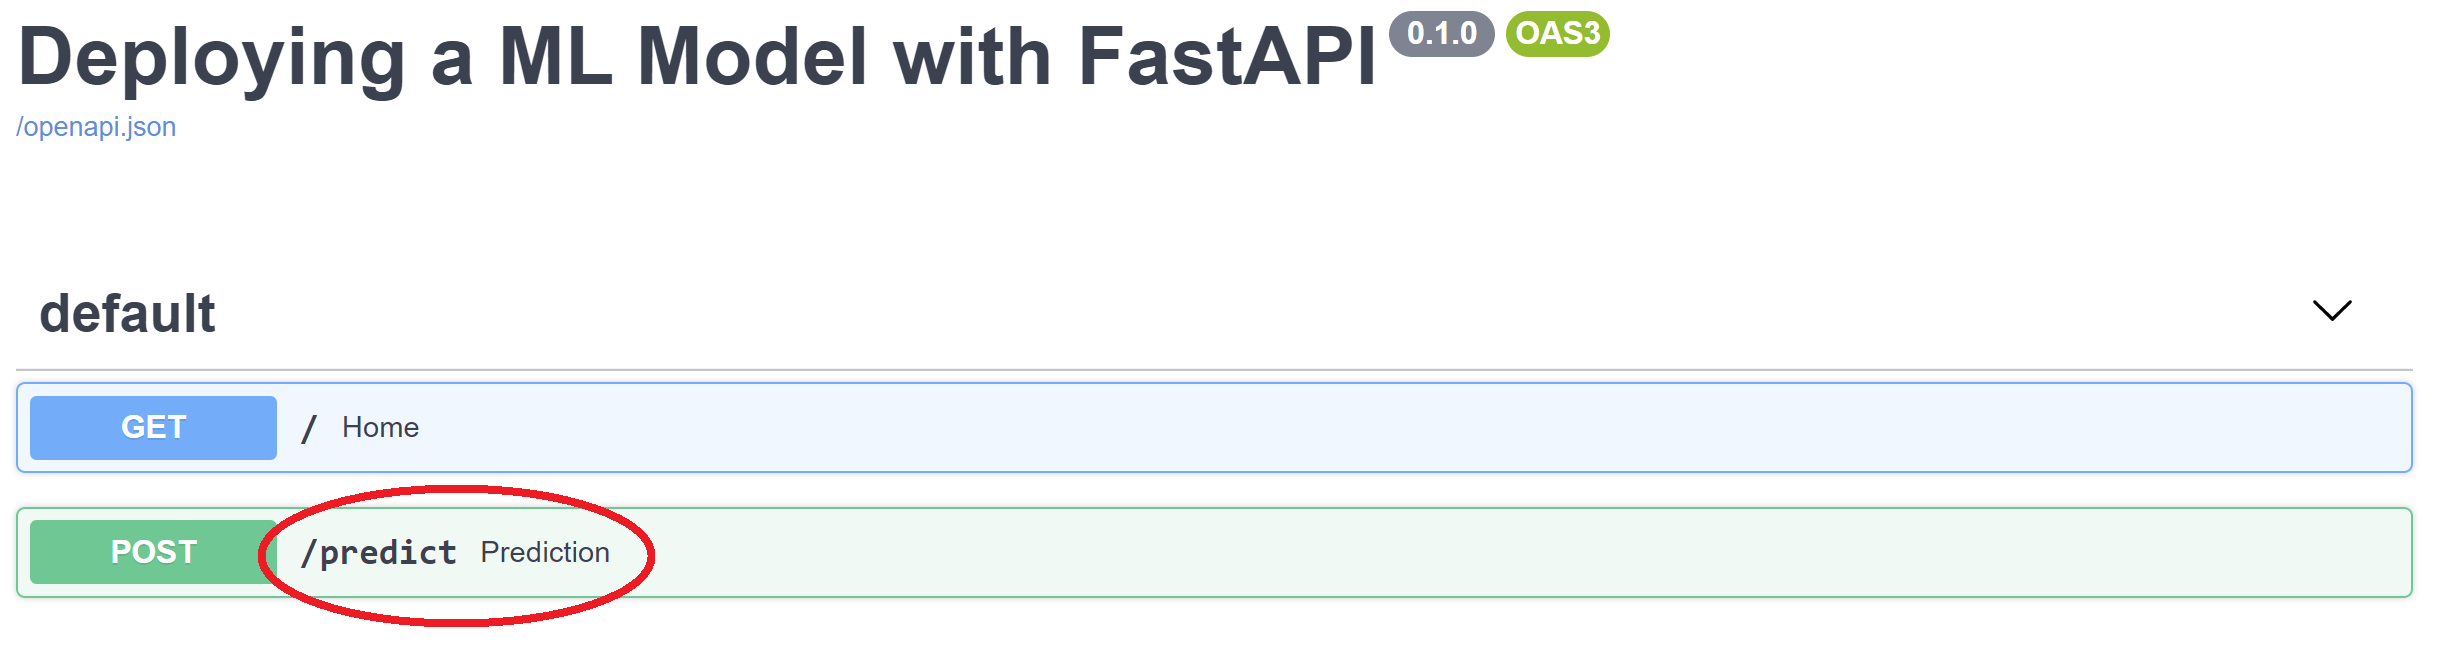



3. Click on the **Try it out** button to test your server

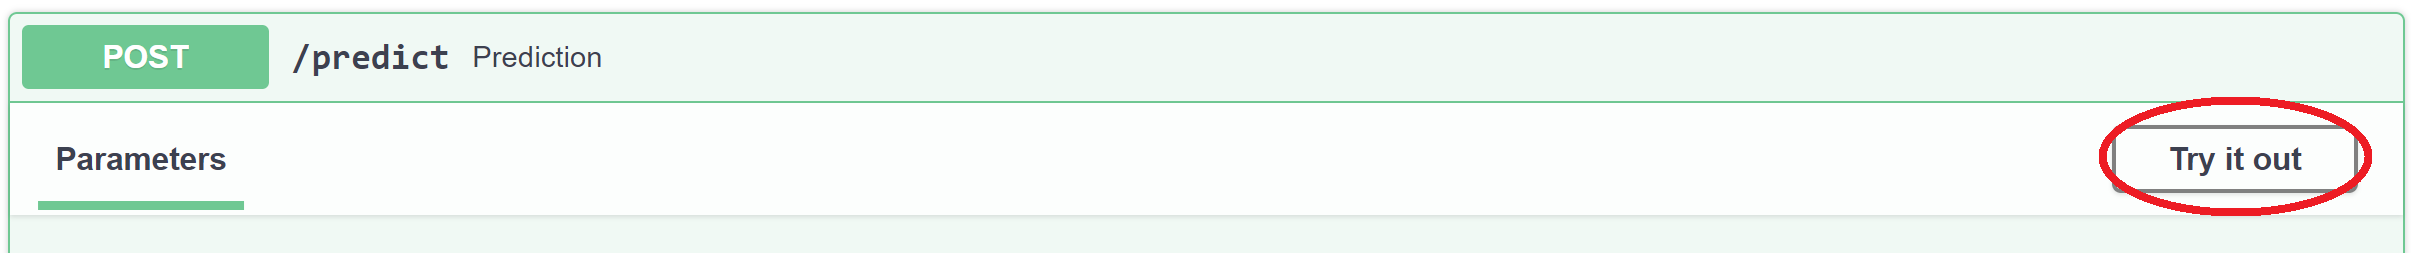

4. Choose a model from the **model** field (if you select the full YOLOV3 model the server will be stuck until the weights for this model are downloaded)

5. Click the **Choose File** button to **submit an image** from your local file system

6. Click on the blue **Execute** button to send an HTTP request to the server. 

7. **Scroll down to see the response from the server**. 

Pretty cool, right?

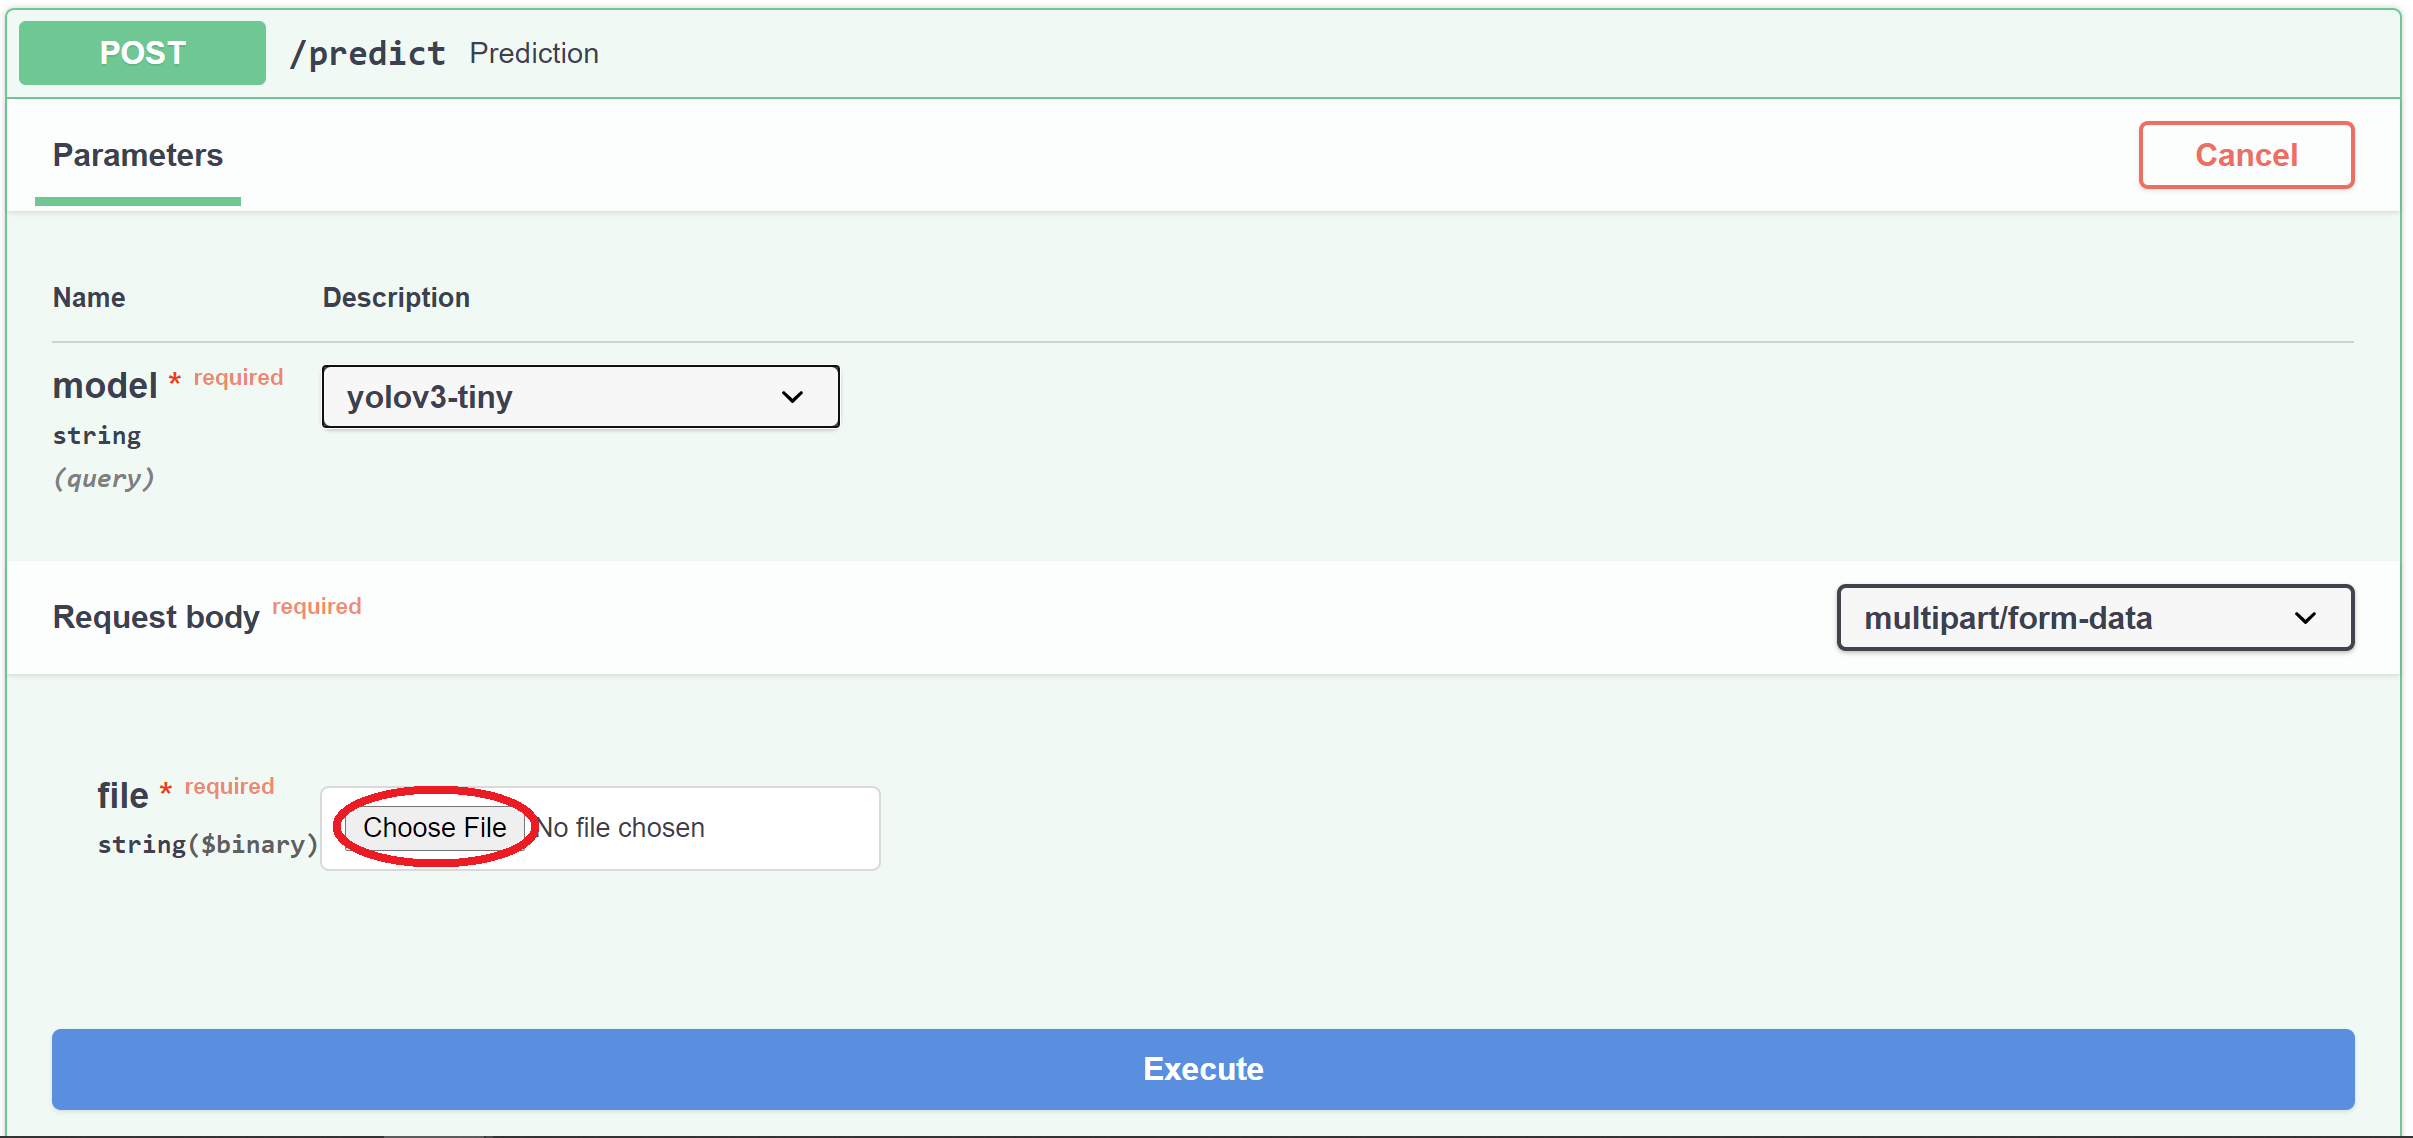

8. **Try different images!** You can use the ones we provided with this lab or some of your own. Since the model is using the default confidence level of 0.5 it might not always succeed at detecting some objects. You can also try submitting non-image files to see how the server reacts to them.

## (Optional) Consuming your model from another client

It is awesome that FastAPI allows you to interact with your API through its built-in client. However, you might wonder how you can interact with your API using regular code and not some UI.

There is a bonus section which shows how to code a minimal client in Python. This is useful to break down (in a very high level) what FastAPI's client is doing under the hood. You can find a notebook named `client-coursera.ipynb` in the file explorer on the left. Double-click on it to open it a new tab, then follow the instructions. Make sure that your server (`uvicorn.run(app, host=host, port=8000, root_path="/serve")`) is still running above before you switch to that notebook.